# Model 3: Deep Neural Network
## Testing across all preprocessing strategies

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from sklearn.metrics import (
    roc_auc_score, average_precision_score, recall_score,
    precision_recall_curve, roc_curve, classification_report,
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

/Users/ankitarathod/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## 1. Load Preprocessed Data

In [2]:
strategies = [
    'strategy1',
    'strategy2a_knn',
    'strategy2b_mice',
    'strategy3_domain'
]

strategy_names = {
    'strategy1': 'Simple (Median/Mode)',
    'strategy2a_knn': 'KNN Imputation',
    'strategy2b_mice': 'MICE Imputation',
    'strategy3_domain': 'Domain-Informed'
}

print("Loading preprocessed datasets for Deep Neural Network...")

Loading preprocessed datasets for Deep Neural Network...


## 2. Define Neural Network Architecture

In [3]:
def create_dnn_model(input_dim, architecture='deep'):
    """
    Create a deep neural network for binary classification
    
    Args:
        input_dim: Number of input features
        architecture: 'deep' or 'wide' network
    """
    model = keras.Sequential()
    
    if architecture == 'deep':
        # Deep architecture: Multiple hidden layers with decreasing size
        model.add(layers.Dense(256, activation='relu', input_dim=input_dim))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(0.3))
        
        model.add(layers.Dense(128, activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(0.3))
        
        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(0.2))
        
        model.add(layers.Dense(32, activation='relu'))
        model.add(layers.Dropout(0.2))
        
    else:  # 'wide'
        # Wide architecture: Fewer but wider layers
        model.add(layers.Dense(512, activation='relu', input_dim=input_dim))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(0.4))
        
        model.add(layers.Dense(256, activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(0.3))
    
    # Output layer
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

print("Neural network architecture defined")

Neural network architecture defined


## 3. Train Deep Neural Networks on Each Strategy

In [4]:
models = {}
predictions = {}
histories = {}

# Training parameters
EPOCHS = 100
BATCH_SIZE = 64
PATIENCE = 15  # Early stopping patience

for strategy in strategies:
    print(f"\n{'='*70}")
    print(f"Training Deep Neural Network - {strategy_names[strategy]}")
    print(f"{'='*70}")
    
    # Load data
    X_train = pd.read_csv(f'preprocessed_data/{strategy}_X_train.csv')
    X_test = pd.read_csv(f'preprocessed_data/{strategy}_X_test.csv')
    
    if 'strategy2' in strategy:
        y_train = pd.read_csv('preprocessed_data/strategy2_y_train.csv')['undetectable']
        y_test = pd.read_csv('preprocessed_data/strategy2_y_test.csv')['undetectable']
    else:
        y_train = pd.read_csv(f'preprocessed_data/{strategy}_y_train.csv')['undetectable']
        y_test = pd.read_csv(f'preprocessed_data/{strategy}_y_test.csv')['undetectable']
    
    print(f"Training shape: {X_train.shape}")
    print(f"Test shape: {X_test.shape}")
    
    # Create model
    input_dim = X_train.shape[1]
    dnn_model = create_dnn_model(input_dim, architecture='deep')
    
    # Calculate class weights for imbalanced data
    class_weight = {
        0: len(y_train) / (2 * (y_train == 0).sum()),
        1: len(y_train) / (2 * (y_train == 1).sum())
    }
    
    # Compile model
    dnn_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            keras.metrics.AUC(name='auc'),
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall')
        ]
    )
    
    print("\nModel Architecture:")
    dnn_model.summary()
    
    # Callbacks
    early_stop = callbacks.EarlyStopping(
        monitor='val_auc',
        patience=PATIENCE,
        mode='max',
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.00001,
        verbose=1
    )
    
    # Train model
    print("\nTraining...")
    history = dnn_model.fit(
        X_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.2,
        class_weight=class_weight,
        callbacks=[early_stop, reduce_lr],
        verbose=0
    )
    
    # Predictions
    y_pred_proba = dnn_model.predict(X_test, verbose=0).flatten()
    y_pred = (y_pred_proba >= 0.5).astype(int)
    
    # Store results
    models[strategy] = dnn_model
    predictions[strategy] = {
        'y_test': y_test,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    histories[strategy] = history
    
    print(f"\nTraining completed!")
    print(f"Epochs trained: {len(history.history['loss'])}")
    print(f"Best validation AUC: {max(history.history['val_auc']):.4f}")

print(f"\nAll Deep Neural Network models trained!")


Training Deep Neural Network - Simple (Median/Mode)
Training shape: (26408, 32)
Test shape: (6603, 32)

Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         8,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,505 (209.00 KB)

 Trainable params: 52,609 (205.50 KB)

 Non-trainable params: 896 (3.50 KB)


Training...



Epoch 31: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.



Epoch 41: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.



Epoch 62: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.



Epoch 77: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.



Epoch 92: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.



Epoch 100: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.


Restoring model weights from the end of the best epoch: 95.



Training completed!
Epochs trained: 100
Best validation AUC: 0.9984

Training Deep Neural Network - KNN Imputation


Training shape: (26408, 32)
Test shape: (6603, 32)

Model Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 256)            │         8,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,505 (209.00 KB)

 Trainable params: 52,609 (205.50 KB)

 Non-trainable params: 896 (3.50 KB)


Training...



Epoch 36: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.



Epoch 45: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.



Epoch 50: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.



Epoch 63: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.



Epoch 75: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.


Epoch 88: early stopping


Restoring model weights from the end of the best epoch: 73.



Training completed!
Epochs trained: 88
Best validation AUC: 0.9970

Training Deep Neural Network - MICE Imputation


Training shape: (26408, 32)
Test shape: (6603, 32)

Model Architecture:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 256)            │         8,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,505 (209.00 KB)

 Trainable params: 52,609 (205.50 KB)

 Non-trainable params: 896 (3.50 KB)


Training...



Epoch 32: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.



Epoch 40: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.



Epoch 57: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.



Epoch 74: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.


Epoch 79: early stopping


Restoring model weights from the end of the best epoch: 64.



Training completed!
Epochs trained: 79
Best validation AUC: 0.9970

Training Deep Neural Network - Domain-Informed


Training shape: (26408, 43)
Test shape: (6603, 43)

Model Architecture:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 256)            │        11,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,321 (220.00 KB)

 Trainable params: 55,425 (216.50 KB)

 Non-trainable params: 896 (3.50 KB)


Training...



Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.



Epoch 38: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.



Epoch 44: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.



Epoch 54: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.


Epoch 57: early stopping


Restoring model weights from the end of the best epoch: 42.



Training completed!
Epochs trained: 57
Best validation AUC: 0.9989

All Deep Neural Network models trained!


## 4. Evaluate Models - AUROC, PR AUC, Recall

In [5]:
evaluation_results = []

for strategy in strategies:
    y_test = predictions[strategy]['y_test']
    y_pred = predictions[strategy]['y_pred']
    y_pred_proba = predictions[strategy]['y_pred_proba']
    
    # Calculate metrics
    auroc = roc_auc_score(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)
    recall = recall_score(y_test, y_pred)
    
    # Calculate recall at specific thresholds
    thresholds = [0.3, 0.5, 0.7]
    recalls_at_thresholds = {}
    for thresh in thresholds:
        y_pred_thresh = (y_pred_proba >= thresh).astype(int)
        recalls_at_thresholds[thresh] = recall_score(y_test, y_pred_thresh)
    
    evaluation_results.append({
        'Strategy': strategy_names[strategy],
        'AUROC': auroc,
        'PR AUC': pr_auc,
        'Recall (default)': recall,
        'Recall @0.3': recalls_at_thresholds[0.3],
        'Recall @0.5': recalls_at_thresholds[0.5],
        'Recall @0.7': recalls_at_thresholds[0.7]
    })

results_df = pd.DataFrame(evaluation_results)
print("\n" + "="*90)
print("DEEP NEURAL NETWORK - EVALUATION RESULTS")
print("="*90)
print(results_df.to_string(index=False))
print("="*90)


DEEP NEURAL NETWORK - EVALUATION RESULTS
            Strategy    AUROC   PR AUC  Recall (default)  Recall @0.3  Recall @0.5  Recall @0.7
Simple (Median/Mode) 0.996984 0.990886          0.997741     0.999548     0.997741     0.995933
      KNN Imputation 0.994885 0.982169          0.996837     1.000000     0.996837     0.994126
     MICE Imputation 0.996226 0.988383          0.998192     1.000000     0.998192     0.995029
     Domain-Informed 0.998801 0.996487          1.000000     1.000000     1.000000     1.000000


## 5. Detailed Classification Reports

In [6]:
for strategy in strategies:
    print(f"\n{'='*70}")
    print(f"Classification Report - {strategy_names[strategy]}")
    print(f"{'='*70}")
    
    y_test = predictions[strategy]['y_test']
    y_pred = predictions[strategy]['y_pred']
    
    print(classification_report(y_test, y_pred, 
                                target_names=['Not Suppressed', 'Suppressed']))
    
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix:")
    print(cm)
    print(f"  [TN={cm[0,0]}, FP={cm[0,1]}]")
    print(f"  [FN={cm[1,0]}, TP={cm[1,1]}]")


Classification Report - Simple (Median/Mode)
                precision    recall  f1-score   support

Not Suppressed       1.00      0.98      0.99      4390
    Suppressed       0.96      1.00      0.98      2213

      accuracy                           0.99      6603
     macro avg       0.98      0.99      0.99      6603
  weighted avg       0.99      0.99      0.99      6603


Confusion Matrix:
[[4308   82]
 [   5 2208]]
  [TN=4308, FP=82]
  [FN=5, TP=2208]

Classification Report - KNN Imputation
                precision    recall  f1-score   support

Not Suppressed       1.00      0.97      0.98      4390
    Suppressed       0.94      1.00      0.97      2213

      accuracy                           0.98      6603
     macro avg       0.97      0.98      0.98      6603
  weighted avg       0.98      0.98      0.98      6603


Confusion Matrix:
[[4258  132]
 [   7 2206]]
  [TN=4258, FP=132]
  [FN=7, TP=2206]

Classification Report - MICE Imputation
                precision   

## 6. Visualization - ROC Curves

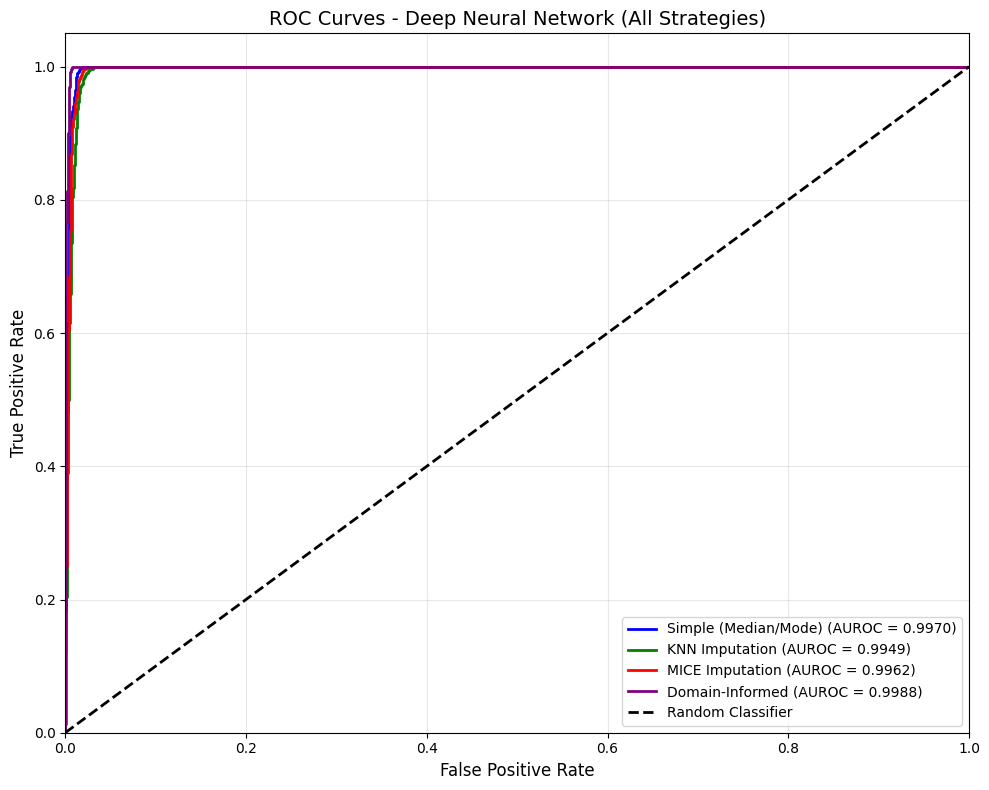

In [7]:
plt.figure(figsize=(10, 8))

colors = ['blue', 'green', 'red', 'purple']

for idx, strategy in enumerate(strategies):
    y_test = predictions[strategy]['y_test']
    y_pred_proba = predictions[strategy]['y_pred_proba']
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auroc = roc_auc_score(y_test, y_pred_proba)
    
    plt.plot(fpr, tpr, color=colors[idx], lw=2,
             label=f'{strategy_names[strategy]} (AUROC = {auroc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Deep Neural Network (All Strategies)', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('dnn_roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Visualization - Precision-Recall Curves

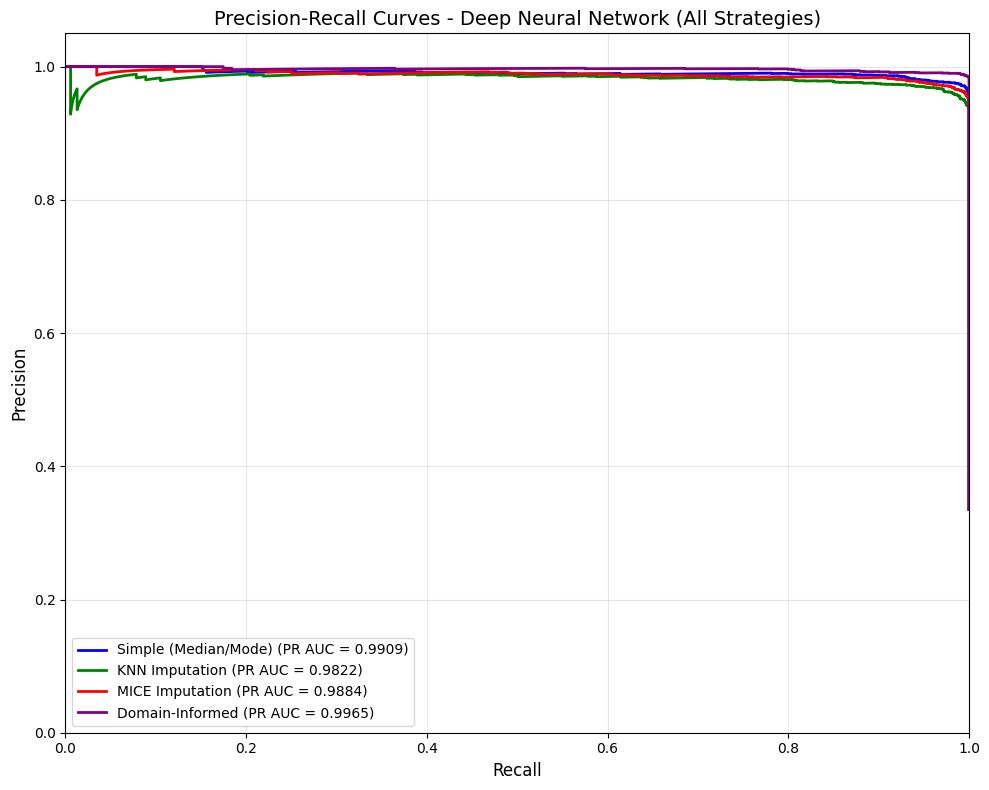

In [8]:
plt.figure(figsize=(10, 8))

for idx, strategy in enumerate(strategies):
    y_test = predictions[strategy]['y_test']
    y_pred_proba = predictions[strategy]['y_pred_proba']
    
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)
    
    plt.plot(recall, precision, color=colors[idx], lw=2,
             label=f'{strategy_names[strategy]} (PR AUC = {pr_auc:.4f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curves - Deep Neural Network (All Strategies)', fontsize=14)
plt.legend(loc='best', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('dnn_pr_curves.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Training History Visualization

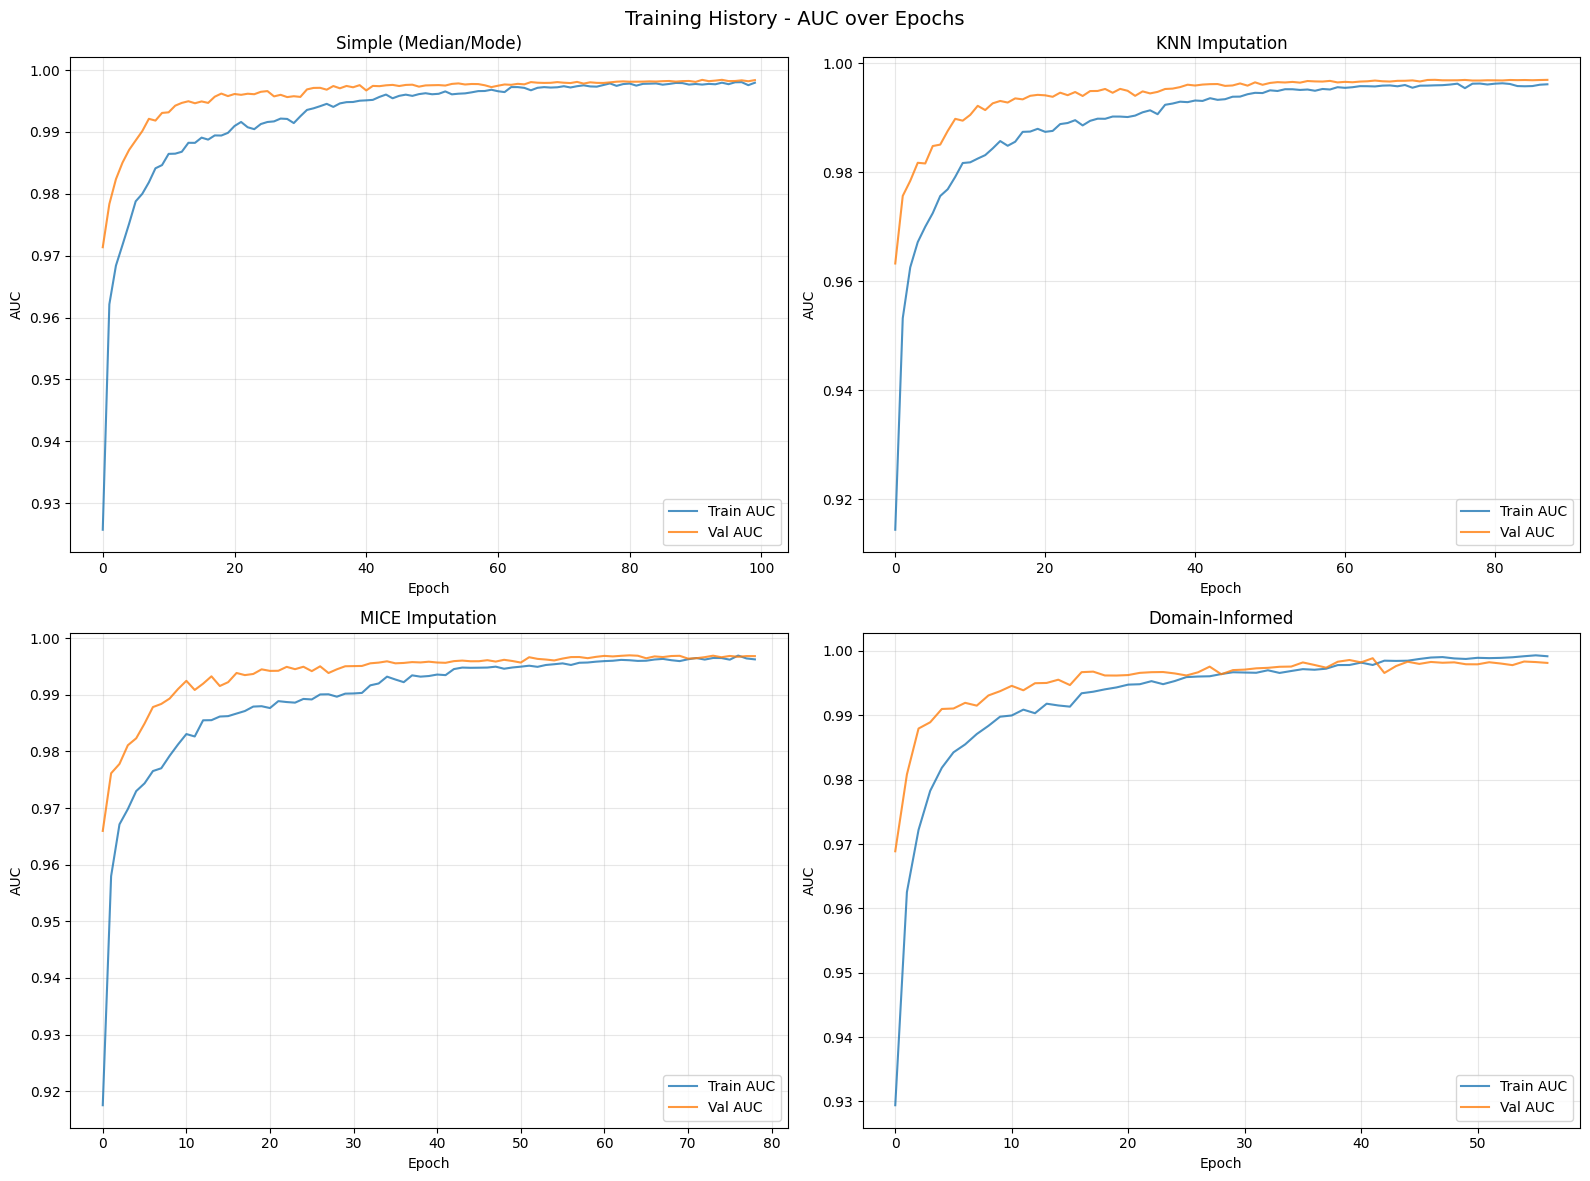

In [9]:
# Plot training history for all strategies
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for idx, strategy in enumerate(strategies):
    history = histories[strategy]
    
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    # Plot training and validation AUC
    ax.plot(history.history['auc'], label='Train AUC', alpha=0.8)
    ax.plot(history.history['val_auc'], label='Val AUC', alpha=0.8)
    
    ax.set_title(f'{strategy_names[strategy]}', fontsize=12)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('AUC')
    ax.legend(loc='lower right')
    ax.grid(alpha=0.3)

plt.suptitle('Training History - AUC over Epochs', fontsize=14)
plt.tight_layout()
plt.savefig('dnn_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. Loss Curves

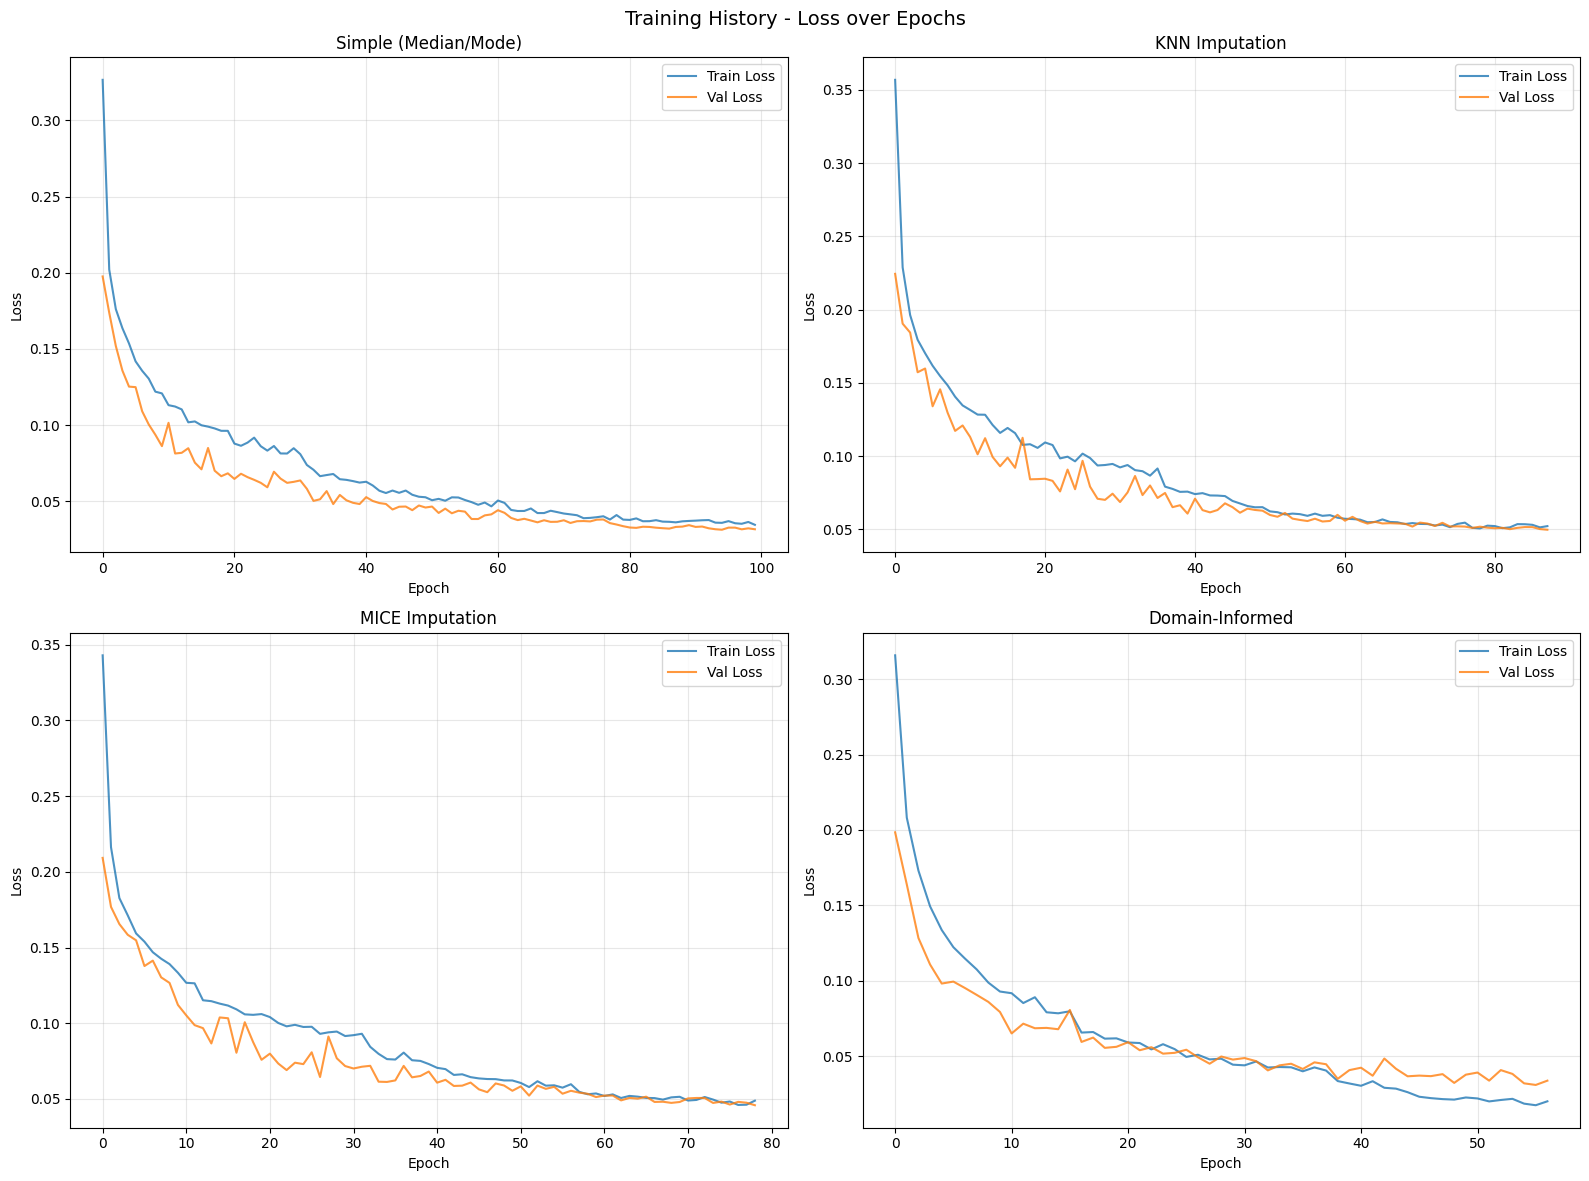

In [10]:
# Plot loss curves
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for idx, strategy in enumerate(strategies):
    history = histories[strategy]
    
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    ax.plot(history.history['loss'], label='Train Loss', alpha=0.8)
    ax.plot(history.history['val_loss'], label='Val Loss', alpha=0.8)
    
    ax.set_title(f'{strategy_names[strategy]}', fontsize=12)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend(loc='upper right')
    ax.grid(alpha=0.3)

plt.suptitle('Training History - Loss over Epochs', fontsize=14)
plt.tight_layout()
plt.savefig('dnn_loss_curves.png', dpi=300, bbox_inches='tight')
plt.show()

## 10. Save Results

In [11]:
import os
os.makedirs('model_results', exist_ok=True)

# Save evaluation results
results_df.to_csv('model_results/dnn_results.csv', index=False)

# Save models
for strategy in strategies:
    models[strategy].save(f'model_results/dnn_{strategy}.h5')

# Save predictions
with open('model_results/dnn_predictions.pkl', 'wb') as f:
    pickle.dump(predictions, f)

# Save training histories
history_dict = {}
for strategy in strategies:
    history_dict[strategy] = histories[strategy].history

with open('model_results/dnn_training_histories.pkl', 'wb') as f:
    pickle.dump(history_dict, f)

print("Results saved to 'model_results/' directory")

Results saved to 'model_results/' directory


## 11. Summary

In [12]:
best_strategy_idx = results_df['AUROC'].idxmax()
best_strategy = strategies[best_strategy_idx]
best_strategy_name = strategy_names[best_strategy]

print("\n" + "="*90)
print("DEEP NEURAL NETWORK - SUMMARY")
print("="*90)

print("\nModel Architecture:")
print("  - Type: Feedforward Deep Neural Network")
print("  - Layers: 4 hidden layers (256 -> 128 -> 64 -> 32)")
print("  - Activation: ReLU (hidden), Sigmoid (output)")
print("  - Regularization: Dropout (0.2-0.3) + Batch Normalization")
print("  - Optimizer: Adam (lr=0.001 with ReduceLROnPlateau)")
print("  - Loss: Binary Crossentropy")
print("  - Class weights: Applied for imbalance")
print(f"  - Max epochs: {EPOCHS}")
print(f"  - Batch size: {BATCH_SIZE}")
print(f"  - Early stopping patience: {PATIENCE}")

print("\nPreprocessing Strategies Tested:")
for strategy in strategies:
    epochs_trained = len(histories[strategy].history['loss'])
    print(f"  - {strategy_names[strategy]}: {epochs_trained} epochs")

print("\nBest Strategy:")
print(f"  - {best_strategy_name}")
print(f"  - AUROC: {results_df.loc[best_strategy_idx, 'AUROC']:.4f}")
print(f"  - PR AUC: {results_df.loc[best_strategy_idx, 'PR AUC']:.4f}")
print(f"  - Recall: {results_df.loc[best_strategy_idx, 'Recall (default)']:.4f}")
print(f"  - Epochs trained: {len(histories[best_strategy].history['loss'])}")

print("\nPerformance Statistics:")
print(f"  - AUROC range: {results_df['AUROC'].min():.4f} - {results_df['AUROC'].max():.4f}")
print(f"  - Average AUROC: {results_df['AUROC'].mean():.4f}")
print(f"  - Average PR AUC: {results_df['PR AUC'].mean():.4f}")
print(f"  - Average Recall: {results_df['Recall (default)'].mean():.4f}")

print("\nKey Advantages of Deep Neural Networks:")
print("  - Learns complex non-linear patterns")
print("  - Automatic feature representation learning")
print("  - Flexible architecture for different data types")
print("  - Can capture high-order interactions")
print("  - Handles large feature spaces well")

print("\n" + "="*90)


DEEP NEURAL NETWORK - SUMMARY

Model Architecture:
  - Type: Feedforward Deep Neural Network
  - Layers: 4 hidden layers (256 -> 128 -> 64 -> 32)
  - Activation: ReLU (hidden), Sigmoid (output)
  - Regularization: Dropout (0.2-0.3) + Batch Normalization
  - Optimizer: Adam (lr=0.001 with ReduceLROnPlateau)
  - Loss: Binary Crossentropy
  - Class weights: Applied for imbalance
  - Max epochs: 100
  - Batch size: 64
  - Early stopping patience: 15

Preprocessing Strategies Tested:
  - Simple (Median/Mode): 100 epochs
  - KNN Imputation: 88 epochs
  - MICE Imputation: 79 epochs
  - Domain-Informed: 57 epochs

Best Strategy:
  - Domain-Informed
  - AUROC: 0.9988
  - PR AUC: 0.9965
  - Recall: 1.0000
  - Epochs trained: 57

Performance Statistics:
  - AUROC range: 0.9949 - 0.9988
  - Average AUROC: 0.9967
  - Average PR AUC: 0.9895
  - Average Recall: 0.9982

Key Advantages of Deep Neural Networks:
  - Learns complex non-linear patterns
  - Automatic feature representation learning
  - Fle